In [723]:
import geopandas as gpd
import pandas as pd
import numpy as np
import glob
import os
import math
import xarray as xr
import itertools
from dateutil.relativedelta import relativedelta
from datacube.utils import geometry
from datacube.utils.geometry import CRS
import datacube 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from shapely.geometry import Point, LineString, MultiPoint
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from sklearn.metrics import mean_squared_error
from scipy import stats

from otps import TimePoint
from otps import predict_tide
from datetime import datetime, timedelta
from datacube.utils.geometry import CRS

def tidal_tag(ds, tidepost_lat=None, tidepost_lon=None, swap_dims=False):
    
    if not tidepost_lat or not tidepost_lon:
        
        tidepost_lon, tidepost_lat = ds.extent.centroid.to_crs(crs=CRS('EPSG:4326')).coords[0]
        print(f'Setting tide post from dataset centroid: {tidepost_lon}, {tidepost_lat}')
        
    else:
        print(f'Using user-supplied tide post: {tidepost_lon}, {tidepost_lat}')
    
    # Use the tidal mode to compute tide heights for each observation:
    obs_datetimes = ds.time.data.astype('M8[s]').astype('O').tolist()
    obs_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) for dt in obs_datetimes]
    obs_predictedtides = predict_tide(obs_timepoints)
    obs_tideheights = [predictedtide.tide_m for predictedtide in obs_predictedtides]

    # Assign tide heights to the dataset as a new variable
    ds['tide_heights'] = xr.DataArray(obs_tideheights, [('time', ds.time)])
    
    # If swap_dims = True, make tide height the primary dimension instead of time
    if swap_dims:
        
        # Swap dimensions and sort by tide height
        ds = ds.swap_dims({'time': 'tide_heights'})
        ds = ds.sortby('tide_heights')        
    
    return ds

# Connect to datacube database
dc_ard = datacube.Datacube(config='/home/561/rt1527/.ard-interoperability_tmp.conf')
dc = datacube.Datacube()

import sys
sys.path.append('../10_Scripts')
import DEAPlotting, SpatialTools

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Extract waterlines for site
To do: look into one pixel leftward offset

In [741]:
site = 'Tweed Entrance'
shoreline_dist = pd.read_csv(f'/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/validation/processed/validation_{site}.csv')
shoreline_dist['date'] = pd.to_datetime(shoreline_dist.date)

xmin, xmax = shoreline_dist.loc[:, ['origin_x', 'end_x']].melt()['value'].quantile([0, 1.0])
ymin, ymax = shoreline_dist.loc[:, ['origin_y', 'end_y']].melt()['value'].quantile([0, 1.0])

DEAPlotting.display_map(x=(xmin, xmax), y=(ymin, ymax), crs='EPSG:28356')
shoreline_dates = shoreline_dist['date'].unique()
shoreline_dates.sort()

DEAPlotting.display_map(x=(xmin, xmax), y=(ymin, ymax), crs='EPSG:32756')

In [733]:
# Set up query
query = {'x': (xmin, xmax),
         'y': (ymin, ymax),
         'time': ('1987-01-01', '2018-12-29'),
         'crs': 'EPSG:32756'}

xarray_dict = {}

for sensor in ['ls5', 'ls7', 'ls8']:

    # Load data in UTM zone coordinates
    landsat_ds = dc_ard.load(product = f'{sensor}_ard', 
                         group_by = 'solar_day', 
                         output_crs = 'EPSG:32756',
                         measurements = ['nbart_green', 'nbart_nir', 'nbart_swir_1',  'fmask'],
                         resolution = (-30, 30),
                         dask_chunks={'time': 1},
                         **query)

    # Identify pixels with valid data: no nodata, no cloud and no cloud shadow
    good_quality = ((landsat_ds.fmask != 0) & 
                    (landsat_ds.fmask != 2) & 
                    (landsat_ds.fmask != 3))

    # Apply mask to set all PQ-affected pixels to NaN and set nodata to NaN
    landsat_ds = landsat_ds.where(good_quality)

    # Compute NDWI and MNDWI 
    landsat_ds['NDWI'] = (landsat_ds.nbart_green - landsat_ds.nbart_nir) / (landsat_ds.nbart_green + landsat_ds.nbart_nir)
    landsat_ds['MNDWI'] = (landsat_ds.nbart_green - landsat_ds.nbart_swir_1) / (landsat_ds.nbart_green + landsat_ds.nbart_swir_1)
    
    xarray_dict[sensor] = landsat_ds
    
landsat_ds = xr.concat(xarray_dict.values(), dim='time')[['MNDWI', 'NDWI']]
landsat_ds = landsat_ds.sortby('time')

In [544]:
# Set up query
query = {'x': (xmin, xmax),
         'y': (ymin, ymax),
         'time': ('1987-01-01', '2018-12-29'),
         'crs': 'EPSG:32756'}

xarray_dict = {}

for sensor in ['ls5', 'ls7', 'ls8']:

    # Load data 
    landsat_ds = dc.load(product = f'{sensor}_nbart_albers', 
                         group_by = 'solar_day', 
#                          output_crs = 'EPSG:32756',
                         measurements = ['green', 'nir', 'swir1'],
#                          resolution = (-30, 30),
                         dask_chunks={'time': 1},
                         **query)

    # Load data in UTM zone coordinates
    landsat_pq = dc.load(product = f'{sensor}_pq_albers', 
                         group_by = 'solar_day', 
#                          output_crs = 'EPSG:32756',
                         measurements = ['pixelquality'],
#                          resolution = (-30, 30),
                         dask_chunks={'time': 1},
                         **query)                       

    # Return only Landsat observations that have matching PQ data 
    time = (landsat_ds.time - landsat_pq.time).time
    landsat_ds = landsat_ds.sel(time=time)
    landsat_pq = landsat_pq.sel(time=time)

    # Create mask
    good_quality = masking.make_mask(landsat_pq.pixelquality,
                                     cloud_acca='no_cloud',
                                     cloud_shadow_acca='no_cloud_shadow',
                                     cloud_shadow_fmask='no_cloud_shadow',
                                     cloud_fmask='no_cloud',
                                     blue_saturated=False,
                                     green_saturated=False,
                                     red_saturated=False,
                                     nir_saturated=False,
                                     swir1_saturated=False,
                                     swir2_saturated=False,
                                     contiguous=True) 
    
    # Apply mask to set all PQ-affected pixels to NaN and set nodata to NaN
    landsat_ds = landsat_ds.where(good_quality)

    # Compute NDWI and MNDWI 
    landsat_ds['NDWI'] = (landsat_ds.green - landsat_ds.nir) / (landsat_ds.green + landsat_ds.nir)
    landsat_ds['MNDWI'] = (landsat_ds.green - landsat_ds.swir1) / (landsat_ds.green + landsat_ds.swir1)
    
    xarray_dict[sensor] = landsat_ds
    
landsat_ds = xr.concat(xarray_dict.values(), dim='time')[['MNDWI', 'NDWI']]
landsat_ds = landsat_ds.sortby('time')

In [535]:
landsat_ds

<xarray.Dataset>
Dimensions:  (time: 953, x: 26, y: 55)
Coordinates:
  * time     (time) datetime64[ns] 1987-05-22T23:07:44.180074 ... 2018-11-19T23:43:39.237351
  * x        (x) float64 3.544e+05 3.544e+05 3.545e+05 ... 3.551e+05 3.552e+05
  * y        (y) float64 6.297e+06 6.297e+06 6.297e+06 ... 6.295e+06 6.295e+06
Data variables:
    MNDWI    (time, y, x) float64 dask.array<shape=(953, 55, 26), chunksize=(1, 55, 26)>
    NDWI     (time, y, x) float64 dask.array<shape=(953, 55, 26), chunksize=(1, 55, 26)>
Attributes:
    crs:      EPSG:32756

## Annual composites

In [734]:
# Pull out selected years
years_to_analyse = shoreline_dist.date.dt.year.unique(); print(years_to_analyse)
landsat_subset = xr.concat([landsat_ds.sel(time=str(i)) for i in years_to_analyse], dim='time')

# Compute tides
landsat_subset = tidal_tag(landsat_subset)

# Tide_adj
datum = 0.0
landsat_subset['adj_0.01'] = ((datum - landsat_subset.tide_heights) / -0.01)
landsat_subset['adj_0.05'] = ((datum - landsat_subset.tide_heights) / -0.05)
landsat_subset['adj_0.10'] = ((datum - landsat_subset.tide_heights) / -0.10)
landsat_subset['adj_0.20'] = ((datum - landsat_subset.tide_heights) / -0.20)

# Load data into memory and take median
out = landsat_subset.compute().groupby('time.year').median(dim='time')


[1999 2004 2007 2010 2014 2016]
Setting tide post from dataset centroid: 153.56032629623076, -28.182670458905143


In [735]:
custom_attrs = {'year': out.year.values.tolist(),
                'tide': out.tide_heights.values.tolist(),
                'adj_0.01': out['adj_0.01'].values.tolist(),
                'adj_0.05': out['adj_0.05'].values.tolist(),
                'adj_0.10': out['adj_0.10'].values.tolist(),
                'adj_0.20': out['adj_0.20'].values.tolist()}
custom_attrs_dtypes = {'year': 'int', 'tide': 'float', 'adj_0.01': 'float', 'adj_0.05': 'float', 'adj_0.10': 'float', 'adj_0.20': 'float'}

metric = 'NDWI'

# Extract contours with custom attribute fields:
contour_gdf = SpatialTools.contour_extract(z_values=0.05,
                                           ds_array=out[metric],
                                           ds_crs=landsat_ds.geobox.crs,
                                           ds_affine=landsat_ds.geobox.affine,
                                           output_shp=f'validation/outputs/landsat_contours_{site}.shp',
                                           attribute_data=custom_attrs,
                                           attribute_dtypes=custom_attrs_dtypes,
                                           min_vertices=2,
                                           verbose=False, dim='year')

Operating in single z-value, multiple arrays mode
Exporting contour shapefile to validation/outputs/landsat_contours_Tweed Entrance.shp


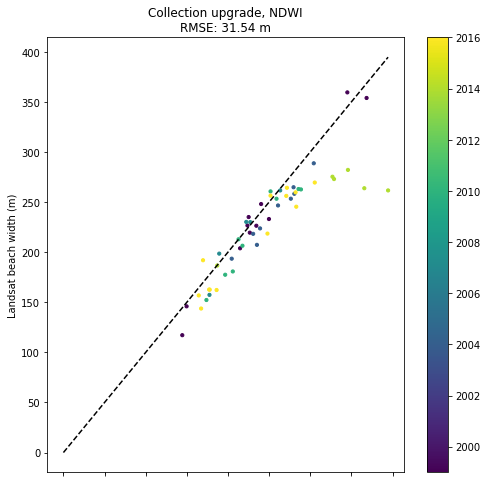

In [742]:
# Import waterline contours
contours_gdf = gpd.read_file(f'validation/outputs/landsat_contours_{site}.shp')
contours_gdf = contours_gdf.to_crs(epsg=28356)  

# Subset to AHD 0.0 data
shoreline_ahd0 = shoreline_dist[['site', 'date', 'ahd0.0_dist', 'ahd0.0_x', 'ahd0.0_y', 'origin_x', 'origin_y', 'end_x', 'end_y', 'foredune_x', 'foredune_y']].dropna()
shoreline_ahd0['year']= shoreline_dist.date.dt.year

# Reduce to year
counts = shoreline_ahd0.groupby([shoreline_ahd0.year, 'site']).count().date
shoreline_ahd0 = shoreline_ahd0.groupby([shoreline_ahd0.year, 'site']).median()
shoreline_ahd0['n'] = counts
shoreline_ahd0 = shoreline_ahd0.reset_index()

# Create geometry for shoreline transects
# shoreline_ahd0_geometry  = shoreline_ahd0.apply(lambda x: LineString([Point(x.origin_x, x.origin_y), Point(x.end_x, x.end_y)]), axis = 1)
shoreline_ahd0_geometry  = shoreline_ahd0.apply(lambda x: LineString([Point(x.foredune_x, x.foredune_y), Point(x.end_x, x.end_y)]), axis = 1)
shoreline_ahd0_gdf = gpd.GeoDataFrame(shoreline_ahd0, geometry=shoreline_ahd0_geometry).reset_index()
shoreline_ahd0_gdf.crs = 'EPSG:28356'

# Combine to match each shoreline contour to each date in validation data
merge_test = shoreline_ahd0_gdf.merge(contours_gdf, on='year')

# For each row, compute distance between origin and location where profile intersects with waterline contour
merge_test['Landsat beach width (m)'] = merge_test.apply(lambda x: x.geometry_x.intersection(x.geometry_y).hausdorff_distance(Point(x.origin_x, x.origin_y)), axis=1)
merge_test = merge_test.rename({'ahd0.0_dist': 'Validation beach width (m)'}, axis=1)
merge_test = merge_test[merge_test['Landsat beach width (m)'] > 0]
merge_test = merge_test[merge_test['Validation beach width (m)'] > 0]

# Optional adjustment for tides
# merge_test['Landsat beach width (m)'] = merge_test['Landsat beach width (m)'] + merge_test['adj_0.05'] 

# Compute difference
merge_test['Difference'] = merge_test['Validation beach width (m)'] - merge_test['Landsat beach width (m)'] 

# merge_test = merge_test[merge_test['Landsat beach width (m)'] < 250]
# merge_test = merge_test[merge_test['Validation beach width (m)'] < 200]
merge_test = merge_test[merge_test.n > 0]
merge_test.head()

# Plot
# merge_test['Landsat beach width (m)'] = merge_test['Landsat beach width (m)'] + 25
rmse = np.round(mean_squared_error(merge_test['Validation beach width (m)'], merge_test['Landsat beach width (m)'])**0.5, 2)
dist_lim = merge_test[['Validation beach width (m)', 'Landsat beach width (m)']].max(axis=0).max()
merge_test[['Validation beach width (m)', 'Landsat beach width (m)']].plot.scatter(x='Validation beach width (m)', 
                                                                                   y='Landsat beach width (m)', 
                                                                                   c=merge_test.year, s=10, cmap='viridis', figsize=(8, 8))  
plt.plot(np.linspace(0, dist_lim), np.linspace(0, dist_lim), 'black', linestyle='dashed')
plt.title(f'Collection upgrade, {metric}\nRMSE: {rmse} m')
plt.savefig(f'{metric}_collectionupgrade_{site}.png')
# plt.title(f'Current collection, {metric}\nRMSE: {rmse} m')
# plt.savefig(f'{metric}_currentcollection_{site}.png')

In [743]:
shoreline_ahd0_gdf.to_file(f'validation/outputs/validation_transect_{site}.shp')

In [744]:
merge_test.sort_values('Difference').head(3)

,index,year,site,Validation beach width (m),ahd0.0_x,ahd0.0_y,origin_x,origin_y,end_x,end_y,...,n,geometry_x,tide,adj_0.01,adj_0.05,adj_0.10,adj_0.20,geometry_y,Landsat beach width (m),Difference
42,42,2016,Tweed Entrance_2_1,169.659750,555393.202500,6.881231e+06,555245.18,6881148.37,555548.03,6881317.75,...,1,"LINESTRING (555358.23 6881211.58, 555548.03 68...",0.122,12.2,2.44,1.22,0.610,(LINESTRING (553995.000000197 6883892.97404894...,191.914454,-22.254704
8,8,1999,Tweed Entrance_5_5,345.061063,554568.881472,6.883754e+06,554234.08,6883670.84,554634.11,6883770.27,...,1,"LINESTRING (554278.4 6883681.83, 554634.11 688...",-0.013,-1.3,-0.26,-0.13,-0.065,(LINESTRING (553995.0000001965 6883889.9269929...,359.436946,-14.375883
2,2,1999,Tweed Entrance_2_1,225.104172,555441.560182,6.881258e+06,555245.18,6881148.37,555548.03,6881317.75,...,1,"LINESTRING (555349.11 6881206.51, 555548.03 68...",-0.013,-1.3,-0.26,-0.13,-0.065,(LINESTRING (553995.0000001965 6883889.9269929...,235.035164,-9.930992


In [745]:
merge_test.sort_values('Difference').tail(3)

,index,year,site,Validation beach width (m),ahd0.0_x,ahd0.0_y,origin_x,origin_y,end_x,end_y,...,n,geometry_x,tide,adj_0.01,adj_0.05,adj_0.10,adj_0.20,geometry_y,Landsat beach width (m),Difference
37,37,2014,Tweed Entrance_5_3,345.786800,554665.920000,6.883366e+06,554330.34,6883282.73,554730.35,6883382.02,...,1,"LINESTRING (554518.52 6883329.52, 554730.35 68...",0.068,6.8,1.36,0.68,0.34,(LINESTRING (553995.0000001969 6883891.7970561...,282.080961,63.705839
38,38,2014,Tweed Entrance_5_4,365.680667,554637.113333,6.883565e+06,554282.21,6883476.79,554682.23,6883576.15,...,1,"LINESTRING (554466.73 6883522.73, 554682.23 68...",0.068,6.8,1.36,0.68,0.34,(LINESTRING (553995.0000001969 6883891.7970561...,263.781514,101.899152
39,39,2014,Tweed Entrance_5_5,394.576000,554617.040000,6.883766e+06,554234.08,6883670.84,554634.11,6883770.27,...,1,"LINESTRING (554246.1 6883674.1, 554634.11 6883...",0.068,6.8,1.36,0.68,0.34,(LINESTRING (553995.0000001969 6883891.7970561...,261.600048,132.975952


In [719]:

geometry_intersect = merge_test.apply(lambda x: x.geometry_x.intersection(x.geometry_y), axis=1)
# geometry_intersect
intersect_ahd0_gdf = gpd.GeoDataFrame(merge_test[['year', 'site']], geometry=geometry_intersect).reset_index()
intersect_ahd0_gdf[intersect_ahd0_gdf.site == 'Avoca_5_1']
# intersect_ahd0_gdf.crs = 'EPSG:28356'
# intersect_ahd0_gdf.to_file(f'validation/outputs/validation_intersect_{site}.shp')

,index,year,site,geometry
156,161,2008,Avoca_5_1,POINT (354655.0001506999 6296086.928368225)


In [699]:
# merge_test.apply(lambda x: MultiPoint([x.geometry_x.intersection(x.geometry_y)]), axis=1)

In [700]:
# merge_test.apply(lambda x: x.geometry_x.intersection(x.geometry_y), axis=1)

## Individual observations

In [ ]:
out = landsat_ds.sel(time=shoreline_dates, method='nearest')
out['time_diff'] = (out.time - shoreline_dates) 
out
# out.time_diff  < np.timedelta64(5,'D')

In [ ]:
out = out.compute()
out

In [ ]:
out = tidal_tag(out)
height = out['tide_heights']
slope = 90
out['x_adj'] = height * math.sin(np.deg2rad(90 - slope)) / math.sin(np.deg2rad(slope))

In [ ]:
custom_attrs = {'date': [str(i)[0:10] for i in shoreline_dates],
                'x_adj': out['x_adj'].values,
                'time_diff': out['time_diff'].values.astype('timedelta64[D]').astype('int16').tolist()
               }
custom_attrs_dtypes = {'date': 'str', 'x_adj': 'int', 'time_diff': 'int'}

# Extract contours with custom attribute fields:
contour_gdf = SpatialTools.contour_extract(z_values=0.0,
                                           ds_array=out.MNDWI,
                                           ds_crs=landsat_ds.geobox.crs,
                                           ds_affine=landsat_ds.geobox.affine,
                                           output_shp=f'validation/outputs/landsat_contours_{site}.shp',
                                           attribute_data=custom_attrs,
                                           attribute_dtypes=custom_attrs_dtypes,
                                           verbose=False)



In [ ]:
# Import waterline contours
contours_gdf = gpd.read_file(f'validation/outputs/landsat_contours_{site}.shp')
contours_gdf = contours_gdf.to_crs(epsg=28356)  
contours_gdf['date'] = pd.to_datetime(contours_gdf.date)

# Subset to AHD 0.0 data
shoreline_ahd0 = shoreline_dist[['date', 'ahd0.0_dist', 'origin_x', 'origin_y', 'end_x', 'end_y']].dropna()
shoreline_ahd0_geometry  = shoreline_ahd0.apply(lambda x: LineString([Point(x.origin_x, x.origin_y), Point(x.end_x, x.end_y)]), axis = 1)
shoreline_ahd0_gdf = gpd.GeoDataFrame(shoreline_ahd0, geometry=shoreline_ahd0_geometry).reset_index()
shoreline_ahd0_gdf.crs = 'EPSG:28356'

# Combine to match each shoreline contour to each date in validation data
merge_test = shoreline_ahd0_gdf.merge(contours_gdf, on='date')

# For each row, compute distance between origin and location where profile intersects with waterline contour
merge_test['Landsat beach width (m)'] = merge_test.apply(lambda x: x.geometry_x.intersection(x.geometry_y).distance(Point(x.origin_x, x.origin_y)), axis=1)
merge_test = merge_test.rename({'ahd0.0_dist': 'Validation beach width (m)'}, axis=1)
merge_test = merge_test[merge_test['Landsat beach width (m)'] > 0]
merge_test.head()

# Modify
merge_test['Landsat beach width (m)'] = merge_test['Landsat beach width (m)']  + merge_test['x_adj']

# Plot
# merge_test['Landsat beach width (m)'] = merge_test['Landsat beach width (m)'] + 25
dist_lim = merge_test[['Validation beach width (m)', 'Landsat beach width (m)']].max(axis=0).max()
merge_test[['Validation beach width (m)', 'Landsat beach width (m)']].plot.scatter(x='Validation beach width (m)', 
                                                                                   y='Landsat beach width (m)', 
                                                                                   c=abs(merge_test.time_diff), s=1, cmap='viridis', figsize=(8, 8))  #
plt.plot(np.linspace(0, dist_lim), np.linspace(0, dist_lim), 'black', linestyle='dashed')
plt.ylim([0, dist_lim]); plt.xlim([0, dist_lim]);


In [ ]:

stats_df = merge_test[(np.abs(stats.zscore(merge_test[['Validation beach width (m)', 'Landsat beach width (m)']])) < 1).all(axis=1)]


mean_squared_error(stats_df['Validation beach width (m)'], stats_df['Landsat beach width (m)'])**0.5

In [ ]:
# merge_test['Landsat beach width (m)'] = merge_test['Landsat beach width (m)'] + 25
dist_lim = stats_df[['Validation beach width (m)', 'Landsat beach width (m)']].max(axis=0).max()
stats_df[['Validation beach width (m)', 'Landsat beach width (m)']].plot.scatter(x='Validation beach width (m)', 
                                                                                   y='Landsat beach width (m)', 
                                                                                   c=abs(stats_df.time_diff), s=1, cmap='viridis', figsize=(8, 8))  #
plt.plot(np.linspace(0, dist_lim), np.linspace(0, dist_lim), 'black', linestyle='dashed')
plt.ylim([0, dist_lim]); plt.xlim([0, dist_lim]);